In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# inspired by https://stackoverflow.com/questions/7391945/how-do-i-read-image-data-from-a-url-in-python
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
from google.colab import drive
drive.mount('/content/drive')
# Set the random seed
np.random.seed(1337)

Mounted at /content/drive


In [2]:
os.chdir("/content/drive/My Drive/paintings_450")
!ls

'Albrecht Durer'	      'Henri Matisse'  'Salvador Dali'
'Alfred Freddy Krupa'	      'Marc Chagall'   'Vincent van Gogh'
'Claude Monet'		      'Pablo Picasso'
'Giovanni Battista Piranesi'   Rembrandt


In [3]:
# inspired by Jas and "https://keras.io/examples/vision/image_classification_from_scratch/"
# split images to training set(80%) and validation set(20%)
# we resize images to 100*100 so we can work quickly
image_size=(100, 100)
# Next, create training(80%), validation(10%) and testing(10%) set
# Create the training set
train_ds = keras.preprocessing.image_dataset_from_directory(
  "/content/drive/My Drive/paintings_450",
  label_mode = "categorical",
  validation_split=0.2,
  subset="training", # We tried subset = "both", but error occurs.
  seed=1337,
  image_size=image_size,
  batch_size=36)
# Create the validation set
val_ds = keras.preprocessing.image_dataset_from_directory(
  "/content/drive/My Drive/paintings_450",
  label_mode = "categorical",
  validation_split=0.2,
  subset="validation",
  seed=1337,
  image_size=image_size,
  batch_size=36)

# Create the testing set
validation_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take((1*validation_batches) // 2)
val_ds = val_ds.skip((1*validation_batches) // 2)

Found 4411 files belonging to 10 classes.
Using 3529 files for training.
Found 4411 files belonging to 10 classes.
Using 882 files for validation.


In [4]:
# we apply random horizontal flipping or small random rotations to augment the dataset since we only have 450 images.

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.15),
    ]
)

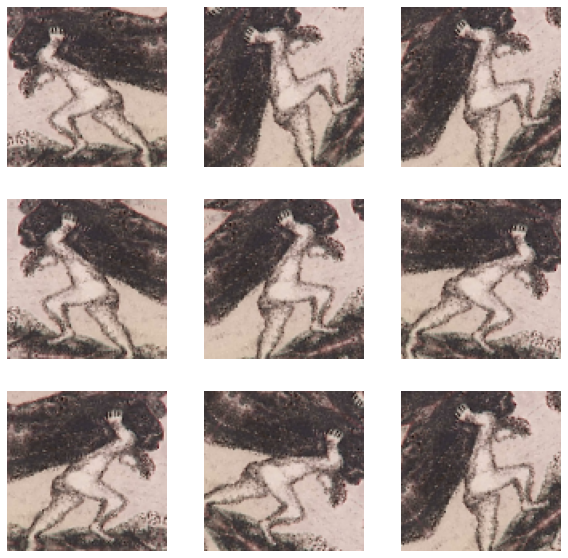

In [6]:
# visualize the augmented samples
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [5]:
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [6]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [9]:
# simple NN model
model = keras.Sequential(
    [
      keras.Input(shape=image_size + (3,)),
      # The original RGB value is not good for NN. Hence we standardize the images to obtain small input values.
      layers.Rescaling(1./255),
      layers.Dense(64, activation= 'relu'), # first hidden layer
      layers.Dense(64, activation= 'relu'), # second hidden layer
      layers.Flatten(),
      layers.Dense(10, activation="softmax"), # output layer
    ]
)

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]) 
model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
99/99 [==============================] - 99s 956ms/step - loss: 7.0890 - accuracy: 0.2474 - val_loss: 1.8625 - val_accuracy: 0.3311
Epoch 2/10
99/99 [==============================] - 93s 908ms/step - loss: 1.8082 - accuracy: 0.3647 - val_loss: 1.8607 - val_accuracy: 0.3644
Epoch 3/10
99/99 [==============================] - 92s 900ms/step - loss: 1.7532 - accuracy: 0.3791 - val_loss: 1.7854 - val_accuracy: 0.3756
Epoch 4/10
99/99 [==============================] - 92s 894ms/step - loss: 1.6804 - accuracy: 0.4148 - val_loss: 1.7620 - val_accuracy: 0.4133
Epoch 5/10
99/99 [==============================] - 104s 1s/step - loss: 1.6955 - accuracy: 0.4174 - val_loss: 1.7441 - val_accuracy: 0.4089
Epoch 6/10
99/99 [==============================] - 98s 958ms/step - loss: 1.6156 - accuracy: 0.4319 - val_loss: 1.6024 - val_accuracy: 0.4556
Epoch 7/10
99/99 [==============================] - 96s 941ms/step - loss: 1.6131 - accuracy: 0.4438 - val_loss: 1.6690 - val_accuracy: 0.4511
E

In [10]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_ds.take(-1), batch_size=36)
print("test loss, test acc:", results)

Evaluate on test data
12/12 [==============================] - 10s 510ms/step - loss: 1.9253 - accuracy: 0.3843
test loss, test acc: [1.925268530845642, 0.38425925374031067]


In [ ]:
# create confusion matrix of training and test errors
predicts = model.predict(test_ds.take(-1), batch_size=36)
test_y = np.argmax(test_y.T, 0)
predicts = np.argmax(predicts.T, 0)
confusion_matr = confusion_matrix(test_y, predicts)
plt.figure(figsize = (16, 9))
sns.heatmap(confusion_matr/np.sum(confusion_matr), fmt='.2%', cmap="Blues", annot=True);
plt.savefig("conf matrix")